In [2]:
import csv
import pandas as pd
from pyblock2.driver.core import DMRGDriver, SymmetryTypes, MPOAlgorithmTypes
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
from pathlib import Path
import os

In [3]:
def current_file_path():
    current_file = os.path.abspath(os.path.dirname(os.getcwd()))
    return current_file

# Data Storing Scripts

In [7]:
def generate_variable_name(params, **kwargs):
    """
    Generate a variable name dynamically based on the given parameters.
    Parameters:
    - params (dict): A dictionary containing 't' and 'theta_foldername' as keys.
    Returns:
    - str: The dynamically generated variable name.
    """
    t_value = params['t']
    u_value = params['u']
    if t_value != 0:
        t_formatted = "{:.1e}".format(t_value).replace("+", "").replace("e0", "e")
    else:
        t_formatted = "0e0"

    if u_value != 0:
        U_formatted = "{:.1e}".format(u_value).replace("+", "").replace("e0", "e")
    else:
        U_formatted = "0e0"
    theta_formatted = params['theta_foldername']
    return f"data_t{t_formatted}_theta{theta_formatted}"

## HDF5 Files

In [246]:
def generating_complete_path_hdf5(filename, **kwargs):
    current_file = current_file_path()
    if params['theta_foldername'] == '0':
        complete_path = os.path.join(current_file, 'AHM_Data_Codes', f'theta{params['theta_foldername']}', f'L{params['L']}', filename)
    else:
        complete_path = os.path.join(current_file, 'AHM_Data_Codes', f'theta_{params['theta_foldername']}', f'L{params['L']}', filename)
    return complete_path

In [238]:
def create_folders_and_store_data(params, data, filename, **kwargs):
    """
    Create folders dynamically based on theta and L values, and store data in a file.
    Writes data - overwrite if file already exists
    Parameters:
    - theta (float or str): The value of theta (e.g., 0, pi/4, pi/2, etc.).
    - L (int): The integer value of L.
    - data (DataFrame): The data to be stored.
    - filename (str): The name of the file to store data in.
    """
    # Define the base directory
    if params['theta_foldername'] == '0':
        base_dir = Path.cwd() / f"theta{params['theta_foldername']}" / f"L{params['L']}"
    else:
        base_dir = Path.cwd() / f"theta_{params['theta_foldername']}" / f"L{params['L']}"
    # Create directories if they don't exist
    base_dir.mkdir(parents=True, exist_ok=True)
    # Define the full file path
    file_path = base_dir / filename
    # Writing the data to a HDF5 file in the created directory
    data.to_hdf(file_path, key=kwargs['key'], mode='w')

In [148]:
def generate_file_name_hdf5(params, **kwargs):
    """
    Generate a file name dynamically based on the given parameters.
    Parameters:
    - params (dict): A dictionary containing 'L', 'nmax', and 't' as keys.
    Returns:
    - str: The dynamically generated file name.
    """
    # Format the 't' value to scientific notation if needed
    t_value = params['t']
    u_value = params['u']
    
    if t_value != 0:
        t_formatted = "{:.1e}".format(t_value).replace("+", "").replace("e0", "e")
    else:
        t_formatted = "0e0"

    if u_value != 0:
        U_formatted = "{:.1e}".format(u_value).replace("+", "").replace("e0", "e")
    else:
        U_formatted = "0e0"

    if 'Correlation' in kwargs:
        file_name = f"L{params['L']}_t{t_formatted}_Nmax{params['NB_MAX']}_Nbosons{params['N_BOSON']}_U{U_formatted}_CorrelationMatrix.h5"
    else:
        file_name = f"L{params['L']}_t{t_formatted}_Nmax{params['NB_MAX']}_Nbosons{params['N_BOSON']}_U{U_formatted}.h5"
    return file_name


In [37]:
def load_matrix_from_hdf5(filepath, **kwargs):
    """
    Load a matrix from an HDF5 file using pandas.
    Parameters:
    - filepath (str or Path): The path to the HDF5 file.
    - key (str): The key to the dataset to load (default is 'correlation_matrix').
    Returns:
    - ndarray: The matrix loaded from the HDF5 file as a NumPy array.
    """
    df = pd.read_hdf(filepath, key=kwargs['key'])
    return df.values  # Convert the DataFrame to a NumPy array


In [251]:
def append_data_to_hdf5(params, data, filename, **kwargs):
    """
    Append data to an existing HDF5 file.
    
    Parameters:
    - file_path (str or Path): The path to the HDF5 file.
    - data (DataFrame or Series): The data to append.
    - key (str): The key under which the data is stored in the HDF5 file.
    """
    data.to_hdf(filename, key=kwargs['key'], mode='a', index=False, append=True)

# Data for a $\theta$, $L$, $N\_{Boson}$, $N\_{Max}$, $U$

In [19]:
params={}
params['L'], params['N_BOSON'] = 10, 10
params['theta_foldername_list'] = ['0', 'Piby4', 'Piby2', '3Piby4', 'Pi']
params['theta'], params['theta_foldername'] = 0, params['theta_foldername_list'][0]
params['t'] = 1
params['u'] = 1
params['mu'] = 0
params['NB_MAX'] = 3 # max n_boson per site
params['theta_list'] = [0, np.pi/4, 3*np.pi/4, np.pi/2, np.pi]
params['t_list'] = np.arange(0.01, 2, 0.1)

driver = DMRGDriver(scratch="./tmp", symm_type=SymmetryTypes.SAny|SymmetryTypes.CPX, n_threads=4)

driver.set_symmetry_groups("U1")
Q = driver.bw.SX

In [20]:
site_basis, site_ops = [], []
for k in range(params['L']):
    basis = [(Q(i), 1) for i in range(params['NB_MAX'] + 1)] 
    ops = {
        "": np.identity(params['NB_MAX'] + 1),                           # identity
        "C": np.diag(np.sqrt(np.arange(1, params['NB_MAX'] + 1)), k=-1), # b+
        "D": np.diag(np.sqrt(np.arange(1, params['NB_MAX'] + 1)), k=1),  # b
        "N": np.diag(np.arange(0, params['NB_MAX'] + 1), k=0),           # particle number
        "A": np.diag(np.sqrt(np.arange(1, params['NB_MAX'] + 1))*np.exp(1j * params['theta'] * np.arange(params['NB_MAX'])), k=-1), # A+_withPhase  
        "B": np.diag(np.sqrt(np.arange(1, params['NB_MAX'] + 1))*np.exp(-1j * params['theta'] * np.arange(params['NB_MAX'])), k=1), # A_withPhase  
    }
    site_basis.append(basis)
    site_ops.append(ops)

## First Excited Gap, Correlation, Number Operator and Entropy Data

#### $t = 0$

In [233]:
params['t'] = 0
driver.initialize_system(n_sites=params['L'], vacuum=Q(0), target=Q(params['N_BOSON']), hamil_init=False)
driver.ghamil = driver.get_custom_hamiltonian(site_basis, site_ops)
b = driver.expr_builder()

# b.add_term("ADCB", np.array([[i, i+1, i+1, i] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("AD", np.array([[i, i+1] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("CB", np.array([[i+1, i] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("N", np.array(np.arange(params['L'])), -(params['mu'] + params['u'] / 2))
b.add_term("NN", np.repeat(np.arange(params['L']), 2), params['u'] / 2)

mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
mps = driver.get_random_mps(tag="KET", bond_dim=50, nroots=2)
energy = driver.dmrg(mpo, mps, n_sweeps=10, bond_dims=[50] * 4 + [100] * 4,
    noises=[1e-4] * 4 + [1e-5] * 4 + [0], thrds=[1e-10] * 8, dav_max_iter=30, iprint=0)

In [234]:
kets = [driver.split_mps(mps, ir, tag="KET-%d" % ir) for ir in range(mps.nroots)]

##### Entropy

In [37]:
entropy1 = driver.get_bipartite_entanglement(kets[0])

In [38]:
update_csv_column("theta0_AHMDmrg_data.csv", 'Entropy', 't', params['t'], str(entropy1))

In [ ]:
#### Data Storing
data_t0_theta0 = [[params['L'], params['t'], params['u'], params['N_BOSON'], params['NB_MAX'], energy[0], mps, energy[1], entropy]]
add_data_to_csv("theta0_AHMDmrg_data.csv", data_t0_theta0)

##### Correlation Matrix

In [235]:
hop_exp_val = np.zeros((params['L'], params['L']), dtype=complex)
for i in range(params['L']):
    for j in range(i, params['L']):
        b = driver.expr_builder()
        b.add_term("CD", np.array([i, j]), 1)  # Hopping operator between i and j            
        hop_mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
        hop_exp_val[i, j] = driver.expectation(kets[0], hop_mpo, kets[0])
        hop_exp_val[j, i] = np.conjugate(hop_exp_val[i, j])

In [252]:
correl_matrix = pd.DataFrame(hop_exp_val)
filename = generate_file_name_hdf5(params, Correlation = True)
# create_folders_and_store_data(params, correl_matrix, filename, key = 'correl_matrix')
filename = generate_file_name_hdf5(params, Correlation = True)
## Complete path of the location of the file
filename1 = generating_complete_path_hdf5(filename)
append_data_to_hdf5(params, correl_matrix, filename1, key = 'correl_matrix')

##### Correlation Rate

In [236]:
middle_index = (params['L'] - 1) // 2
correlation_rate = hop_exp_val[middle_index, :]

In [240]:
correl_rate = pd.DataFrame(correlation_rate)
filename = generate_file_name_hdf5(params, Correlation = True)
append_data_to_hdf5(params, correl_rate, filename, key = 'correl_rate')

##### Testing of Correlation Matrix by plotting it

In [ ]:
theta_values = [0]
L_values = [10]

example_data = pd.DataFrame({
    'Column1': np.random.rand(10),
    'Column2': np.random.rand(10)
})

for theta in theta_values:
    for L in L_values:
        filename = generate_file_name_hdf5(params)
        create_folders_and_store_data(params, example_data, filename)

In [47]:
filename = generate_file_name_hdf5(params, Correlation = True)

In [50]:
current_file = os.path.abspath(os.path.dirname(os.getcwd()))
filename1 = os.path.join(current_file, 'AHM_Data_Codes', 'theta0', f'L{10}', filename)

In [54]:
hop_exp_val1 = load_matrix_from_hdf5(filename1, key = 'data')

In [57]:
hop_exp_val1 = np.power(np.abs(hop_exp_val1), 2)
plt.imshow(hop_exp_val1, cmap="Blues")

##### Some Minor Testing of Scaling Laws

In [9]:
kets = [driver.split_mps(mps, ir, tag="KET-%d" % ir) for ir in range(mps.nroots)]

In [30]:
entropy1 = driver.get_bipartite_entanglement(kets[0])

In [33]:
params['t'] = 0
update_csv_column("theta0_AHMDmrg_data.csv", 'Entropy', 't', params['t'], str(entropy1))

In [19]:
print(kets[0])
print(entropy1)

[-8.88178420e-16 -8.88178420e-16 -8.88178420e-16 -8.88178420e-16
 -8.88178420e-16 -8.88139235e-16  2.63409891e-10  1.22678750e-10
  8.13411184e-11]


In [20]:
entropy2 = driver.get_bipartite_entanglement(kets[1])
print(entropy2)

[0.00000000e+000 3.41084312e-162 1.30021674e-078 9.50087542e-047
 1.20819030e-014 9.63085519e-012 3.28992598e-002 7.32875617e-001
 8.51719905e-001]


In [29]:
df = pd.read_csv("theta0_AHMDmrg_data.csv")
params['t'] = 0
condition = df['t'] == params['t']
df.loc[condition, 'Entropy'] = str(entropy1) * condition.sum()

# Step 4: Save the updated DataFrame back to the CSV file
df.to_csv("theta0_AHMDmrg_data.csv", index=False)


In [27]:
df.to_pickle("dataframe.pkl")

[-8.8817842e-16, -8.8817842e-16, -8.8817842e-16, -8.8817842e-16, -8.8817842e-16, -8.88139235e-16, 2.63409891e-10, 1.2267875e-10, 8.13411184e-11]


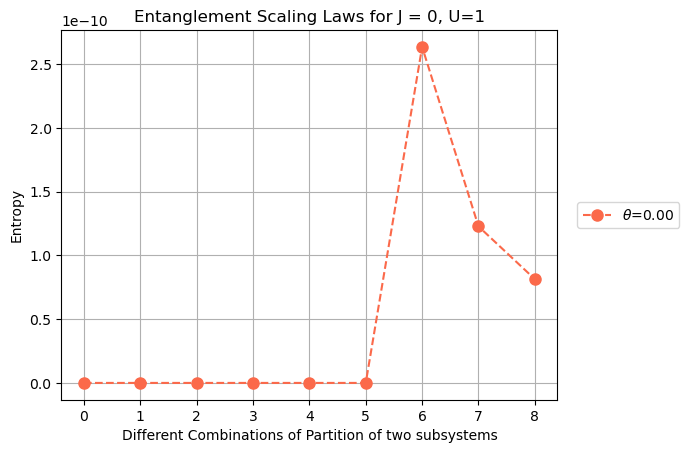

In [28]:
def convert_stringlist_to_float_list(string):
    # Remove the square brackets and split by spaces
    float_list = list(map(float, string.strip('[]').split()))
    return float_list

def get_data_by_conditions(df, conditions, columns):
    condition = pd.Series([True] * len(df)) 
    for key, value in conditions.items():
        condition &= df[key] == value
    filtered_df = df[condition]
    return filtered_df[columns] if not filtered_df.empty else None
colors1 = plt.cm.Reds(np.linspace(0.5, 0.95, len(params['theta_list'])))
conditions = {'t': 0} 
keywords = ['Entropy']
result = get_data_by_conditions(df, conditions, keywords)
entropy = convert_stringlist_to_float_list(result.values[0][0])
print(entropy)
plt.plot(list(range(len(entropy))), entropy, "--o", label=f'$θ$={params['theta_list'][0]:.2f}', color = colors1[0], ms=8)
plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)
plt.xlabel('Different Combinations of Partition of two subsystems')
plt.ylabel('Entropy')
U, t = params['u'], 0
plt.title(f'Entanglement Scaling Laws for J = {t}, U={U}')
plt.grid(True)
plt.show() 

#### $t = 0.1$

In [153]:
params['t'] = 0.1
driver.initialize_system(n_sites=params['L'], vacuum=Q(0), target=Q(params['N_BOSON']), hamil_init=False)
driver.ghamil = driver.get_custom_hamiltonian(site_basis, site_ops)
b = driver.expr_builder()

# b.add_term("ADCB", np.array([[i, i+1, i+1, i] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("AD", np.array([[i, i+1] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("CB", np.array([[i+1, i] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("N", np.array(np.arange(params['L'])), -(params['mu'] + params['u'] / 2))
b.add_term("NN", np.repeat(np.arange(params['L']), 2), params['u'] / 2)

mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
mps = driver.get_random_mps(tag="KET", bond_dim=50, nroots=2)
energy = driver.dmrg(mpo, mps, n_sweeps=10, bond_dims=[50] * 4 + [100] * 4,
    noises=[1e-4] * 4 + [1e-5] * 4 + [0], thrds=[1e-10] * 8, dav_max_iter=30, iprint=0)

In [154]:
kets = [driver.split_mps(mps, ir, tag="KET-%d" % ir) for ir in range(mps.nroots)]

##### Entropy

In [40]:
entropy1 = driver.get_bipartite_entanglement(kets[0])
update_csv_column("theta0_AHMDmrg_data.csv", 'Entropy', 't', params['t'], str(entropy1))

In [ ]:
#### Data Storing
data_t0_1_theta0 = [[params['L'], params['t'], params['u'], params['N_BOSON'], params['NB_MAX'], energy[0], mps, energy[1], entropy]]
add_data_to_csv("theta0_AHMDmrg_data.csv", data_t0_1_theta0)

##### Correlation Matrix

In [155]:
hop_exp_val = np.zeros((params['L'], params['L']), dtype=complex)
for i in range(params['L']):
    for j in range(i, params['L']):
        b = driver.expr_builder()
        b.add_term("CD", np.array([i, j]), 1)  # Hopping operator between i and j            
        hop_mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
        hop_exp_val[i, j] = driver.expectation(kets[0], hop_mpo, kets[0])
        hop_exp_val[j, i] = np.conjugate(hop_exp_val[i, j])

In [156]:
correl_matrix = pd.DataFrame(hop_exp_val)
filename = generate_file_name_hdf5(params, Correlation = True)
create_folders_and_store_data(params, correl_matrix, filename, key = 'correl_matrix')

##### Correlation Rate

In [ ]:
middle_index = (params['L'] - 1) // 2
correlation_rate = hop_exp_val[middle_index, :]

In [ ]:
correl_rate = pd.DataFrame(correlation_rate)
filename = generate_file_name_hdf5(params, Correlation = True)
create_folders_and_store_data(params, filename, correlation_rate, key = 'correl_rate')

#### $t = 0.2$

In [157]:
params['t'] = 0.2
driver.initialize_system(n_sites=params['L'], vacuum=Q(0), target=Q(params['N_BOSON']), hamil_init=False)
driver.ghamil = driver.get_custom_hamiltonian(site_basis, site_ops)
b = driver.expr_builder()

# b.add_term("ADCB", np.array([[i, i+1, i+1, i] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("AD", np.array([[i, i+1] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("CB", np.array([[i+1, i] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("N", np.array(np.arange(params['L'])), -(params['mu'] + params['u'] / 2))
b.add_term("NN", np.repeat(np.arange(params['L']), 2), params['u'] / 2)

mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
mps = driver.get_random_mps(tag="KET", bond_dim=50, nroots=2)
energy = driver.dmrg(mpo, mps, n_sweeps=10, bond_dims=[50] * 4 + [100] * 4,
    noises=[1e-4] * 4 + [1e-5] * 4 + [0], thrds=[1e-10] * 8, dav_max_iter=30, iprint=0)

In [158]:
kets = [driver.split_mps(mps, ir, tag="KET-%d" % ir) for ir in range(mps.nroots)]

##### Entropy

In [42]:
entropy1 = driver.get_bipartite_entanglement(kets[0])
update_csv_column("theta0_AHMDmrg_data.csv", 'Entropy', 't', params['t'], str(entropy1))

In [ ]:
#### Data Storing
data_t0_2_theta0 = [[params['L'], params['t'], params['u'], params['N_BOSON'], params['NB_MAX'], energy[0], mps, energy[1], entropy]]
add_data_to_csv("theta0_AHMDmrg_data.csv", data_t0_2_theta0)

##### Correlation Matrix and Rate

In [159]:
hop_exp_val = np.zeros((params['L'], params['L']), dtype=complex)
for i in range(params['L']):
    for j in range(i, params['L']):
        b = driver.expr_builder()
        b.add_term("CD", np.array([i, j]), 1)  # Hopping operator between i and j            
        hop_mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
        hop_exp_val[i, j] = driver.expectation(kets[0], hop_mpo, kets[0])
        hop_exp_val[j, i] = np.conjugate(hop_exp_val[i, j])

In [160]:
correl_matrix = pd.DataFrame(hop_exp_val)
filename = generate_file_name_hdf5(params, Correlation = True)
create_folders_and_store_data(params, correl_matrix, filename, key = 'correl_matrix')

#### $t = 0.3$

In [161]:
params['t'] = 0.3
driver.initialize_system(n_sites=params['L'], vacuum=Q(0), target=Q(params['N_BOSON']), hamil_init=False)
driver.ghamil = driver.get_custom_hamiltonian(site_basis, site_ops)
b = driver.expr_builder()

# b.add_term("ADCB", np.array([[i, i+1, i+1, i] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("AD", np.array([[i, i+1] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("CB", np.array([[i+1, i] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("N", np.array(np.arange(params['L'])), -(params['mu'] + params['u'] / 2))
b.add_term("NN", np.repeat(np.arange(params['L']), 2), params['u'] / 2)

mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
mps = driver.get_random_mps(tag="KET", bond_dim=50, nroots=2)
energy = driver.dmrg(mpo, mps, n_sweeps=10, bond_dims=[50] * 4 + [100] * 4,
    noises=[1e-4] * 4 + [1e-5] * 4 + [0], thrds=[1e-10] * 8, dav_max_iter=30, iprint=0)

In [162]:
kets = [driver.split_mps(mps, ir, tag="KET-%d" % ir) for ir in range(mps.nroots)]

##### Entropy

In [44]:
entropy1 = driver.get_bipartite_entanglement(kets[0])
update_csv_column("theta0_AHMDmrg_data.csv", 'Entropy', 't', params['t'], str(entropy1))

In [ ]:
#### Data Storing
data_t0_3_theta0 = [[params['L'], params['t'], params['u'], params['N_BOSON'], params['NB_MAX'], energy[0], mps, energy[1], entropy]]
add_data_to_csv("theta0_AHMDmrg_data.csv", data_t0_3_theta0)

##### Correlation Matrix and Rate

In [163]:
hop_exp_val = np.zeros((params['L'], params['L']), dtype=complex)
for i in range(params['L']):
    for j in range(i, params['L']):
        b = driver.expr_builder()
        b.add_term("CD", np.array([i, j]), 1)  # Hopping operator between i and j            
        hop_mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
        hop_exp_val[i, j] = driver.expectation(kets[0], hop_mpo, kets[0])
        hop_exp_val[j, i] = np.conjugate(hop_exp_val[i, j])

In [164]:
correl_matrix = pd.DataFrame(hop_exp_val)
filename = generate_file_name_hdf5(params, Correlation = True)
create_folders_and_store_data(params, correl_matrix, filename, key = 'correl_matrix')

#### $t = 0.4$

In [165]:
params['t'] = 0.4
driver.initialize_system(n_sites=params['L'], vacuum=Q(0), target=Q(params['N_BOSON']), hamil_init=False)
driver.ghamil = driver.get_custom_hamiltonian(site_basis, site_ops)
b = driver.expr_builder()

# b.add_term("ADCB", np.array([[i, i+1, i+1, i] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("AD", np.array([[i, i+1] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("CB", np.array([[i+1, i] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("N", np.array(np.arange(params['L'])), -(params['mu'] + params['u'] / 2))
b.add_term("NN", np.repeat(np.arange(params['L']), 2), params['u'] / 2)

mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
mps = driver.get_random_mps(tag="KET", bond_dim=50, nroots=2)
energy = driver.dmrg(mpo, mps, n_sweeps=10, bond_dims=[50] * 4 + [100] * 4,
    noises=[1e-4] * 4 + [1e-5] * 4 + [0], thrds=[1e-10] * 8, dav_max_iter=30, iprint=0)

In [166]:
kets = [driver.split_mps(mps, ir, tag="KET-%d" % ir) for ir in range(mps.nroots)]

##### Entropy

In [46]:
entropy1 = driver.get_bipartite_entanglement(kets[0])
update_csv_column("theta0_AHMDmrg_data.csv", 'Entropy', 't', params['t'], str(entropy1))

In [ ]:
#### Data Storing
data_t0_4_theta0 = [[params['L'], params['t'], params['u'], params['N_BOSON'], params['NB_MAX'], energy[0], mps, energy[1], entropy]]
add_data_to_csv("theta0_AHMDmrg_data.csv", data_t0_4_theta0)

##### Correlation Matrix and Rate

In [167]:
hop_exp_val = np.zeros((params['L'], params['L']), dtype=complex)
for i in range(params['L']):
    for j in range(i, params['L']):
        b = driver.expr_builder()
        b.add_term("CD", np.array([i, j]), 1)  # Hopping operator between i and j            
        hop_mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
        hop_exp_val[i, j] = driver.expectation(kets[0], hop_mpo, kets[0])
        hop_exp_val[j, i] = np.conjugate(hop_exp_val[i, j])

In [168]:
correl_matrix = pd.DataFrame(hop_exp_val)
filename = generate_file_name_hdf5(params, Correlation = True)
create_folders_and_store_data(params, correl_matrix, filename, key = 'correl_matrix')

#### $t = 0.5$

In [169]:
params['t'] = 0.5
driver.initialize_system(n_sites=params['L'], vacuum=Q(0), target=Q(params['N_BOSON']), hamil_init=False)
driver.ghamil = driver.get_custom_hamiltonian(site_basis, site_ops)
b = driver.expr_builder()

# b.add_term("ADCB", np.array([[i, i+1, i+1, i] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("AD", np.array([[i, i+1] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("CB", np.array([[i+1, i] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("N", np.array(np.arange(params['L'])), -(params['mu'] + params['u'] / 2))
b.add_term("NN", np.repeat(np.arange(params['L']), 2), params['u'] / 2)

mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
mps = driver.get_random_mps(tag="KET", bond_dim=50, nroots=2)
energy = driver.dmrg(mpo, mps, n_sweeps=10, bond_dims=[50] * 4 + [100] * 4,
    noises=[1e-4] * 4 + [1e-5] * 4 + [0], thrds=[1e-10] * 8, dav_max_iter=30, iprint=0)

In [170]:
kets = [driver.split_mps(mps, ir, tag="KET-%d" % ir) for ir in range(mps.nroots)]

##### Entropy

In [48]:
entropy1 = driver.get_bipartite_entanglement(kets[0])
update_csv_column("theta0_AHMDmrg_data.csv", 'Entropy', 't', params['t'], str(entropy1))

In [ ]:
#### Data Storing
data_t0_5_theta0 = [[params['L'], params['t'], params['u'], params['N_BOSON'], params['NB_MAX'], energy[0], mps, energy[1], entropy]]
add_data_to_csv("theta0_AHMDmrg_data.csv", data_t0_5_theta0)

##### Correlation Matrix and Rate

In [171]:
hop_exp_val = np.zeros((params['L'], params['L']), dtype=complex)
for i in range(params['L']):
    for j in range(i, params['L']):
        b = driver.expr_builder()
        b.add_term("CD", np.array([i, j]), 1)  # Hopping operator between i and j            
        hop_mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
        hop_exp_val[i, j] = driver.expectation(kets[0], hop_mpo, kets[0])
        hop_exp_val[j, i] = np.conjugate(hop_exp_val[i, j])

In [172]:
correl_matrix = pd.DataFrame(hop_exp_val)
filename = generate_file_name_hdf5(params, Correlation = True)
create_folders_and_store_data(params, correl_matrix, filename, key = 'correl_matrix')

#### $t = 0.6$

In [173]:
params['t'] = 0.6
driver.initialize_system(n_sites=params['L'], vacuum=Q(0), target=Q(params['N_BOSON']), hamil_init=False)
driver.ghamil = driver.get_custom_hamiltonian(site_basis, site_ops)
b = driver.expr_builder()

# b.add_term("ADCB", np.array([[i, i+1, i+1, i] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("AD", np.array([[i, i+1] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("CB", np.array([[i+1, i] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("N", np.array(np.arange(params['L'])), -(params['mu'] + params['u'] / 2))
b.add_term("NN", np.repeat(np.arange(params['L']), 2), params['u'] / 2)

mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
mps = driver.get_random_mps(tag="KET", bond_dim=50, nroots=2)
energy = driver.dmrg(mpo, mps, n_sweeps=10, bond_dims=[50] * 4 + [100] * 4,
    noises=[1e-4] * 4 + [1e-5] * 4 + [0], thrds=[1e-10] * 8, dav_max_iter=30, iprint=0)

In [174]:
kets = [driver.split_mps(mps, ir, tag="KET-%d" % ir) for ir in range(mps.nroots)]

##### Entropy

In [50]:
entropy1 = driver.get_bipartite_entanglement(kets[0])
update_csv_column("theta0_AHMDmrg_data.csv", 'Entropy', 't', params['t'], str(entropy1))

In [ ]:
#### Data Storing
data_t0_6_theta0 = [[params['L'], params['t'], params['u'], params['N_BOSON'], params['NB_MAX'], energy[0], mps, energy[1], entropy]]
add_data_to_csv("theta0_AHMDmrg_data.csv", data_t0_6_theta0)

##### Correlation Matrix and Rate

In [175]:
hop_exp_val = np.zeros((params['L'], params['L']), dtype=complex)
for i in range(params['L']):
    for j in range(i, params['L']):
        b = driver.expr_builder()
        b.add_term("CD", np.array([i, j]), 1)  # Hopping operator between i and j            
        hop_mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
        hop_exp_val[i, j] = driver.expectation(kets[0], hop_mpo, kets[0])
        hop_exp_val[j, i] = np.conjugate(hop_exp_val[i, j])

In [176]:
correl_matrix = pd.DataFrame(hop_exp_val)
filename = generate_file_name_hdf5(params, Correlation = True)
create_folders_and_store_data(params, correl_matrix, filename, key = 'correl_matrix')

#### $t = 0.7$

In [177]:
params['t'] = 0.7
driver.initialize_system(n_sites=params['L'], vacuum=Q(0), target=Q(params['N_BOSON']), hamil_init=False)
driver.ghamil = driver.get_custom_hamiltonian(site_basis, site_ops)
b = driver.expr_builder()

# b.add_term("ADCB", np.array([[i, i+1, i+1, i] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("AD", np.array([[i, i+1] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("CB", np.array([[i+1, i] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("N", np.array(np.arange(params['L'])), -(params['mu'] + params['u'] / 2))
b.add_term("NN", np.repeat(np.arange(params['L']), 2), params['u'] / 2)

mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
mps = driver.get_random_mps(tag="KET", bond_dim=50, nroots=2)
energy = driver.dmrg(mpo, mps, n_sweeps=10, bond_dims=[50] * 4 + [100] * 4,
    noises=[1e-4] * 4 + [1e-5] * 4 + [0], thrds=[1e-10] * 8, dav_max_iter=30, iprint=0)

In [178]:
kets = [driver.split_mps(mps, ir, tag="KET-%d" % ir) for ir in range(mps.nroots)]

##### Entropy

In [52]:
entropy1 = driver.get_bipartite_entanglement(kets[0])
update_csv_column("theta0_AHMDmrg_data.csv", 'Entropy', 't', params['t'], str(entropy1))

In [ ]:
#### Data Storing
data_t0_7_theta0 = [[params['L'], params['t'], params['u'], params['N_BOSON'], params['NB_MAX'], energy[0], mps, energy[1], entropy]]
add_data_to_csv("theta0_AHMDmrg_data.csv", data_t0_7_theta0)

##### Correlation Matrix and Rate

In [179]:
hop_exp_val = np.zeros((params['L'], params['L']), dtype=complex)
for i in range(params['L']):
    for j in range(i, params['L']):
        b = driver.expr_builder()
        b.add_term("CD", np.array([i, j]), 1)  # Hopping operator between i and j            
        hop_mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
        hop_exp_val[i, j] = driver.expectation(kets[0], hop_mpo, kets[0])
        hop_exp_val[j, i] = np.conjugate(hop_exp_val[i, j])

In [180]:
correl_matrix = pd.DataFrame(hop_exp_val)
filename = generate_file_name_hdf5(params, Correlation = True)
create_folders_and_store_data(params, correl_matrix, filename, key = 'correl_matrix')

#### $t = 0.8$

In [181]:
params['t'] = 0.8
driver.initialize_system(n_sites=params['L'], vacuum=Q(0), target=Q(params['N_BOSON']), hamil_init=False)
driver.ghamil = driver.get_custom_hamiltonian(site_basis, site_ops)
b = driver.expr_builder()

# b.add_term("ADCB", np.array([[i, i+1, i+1, i] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("AD", np.array([[i, i+1] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("CB", np.array([[i+1, i] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("N", np.array(np.arange(params['L'])), -(params['mu'] + params['u'] / 2))
b.add_term("NN", np.repeat(np.arange(params['L']), 2), params['u'] / 2)

mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
mps = driver.get_random_mps(tag="KET", bond_dim=50, nroots=2)
energy = driver.dmrg(mpo, mps, n_sweeps=10, bond_dims=[50] * 4 + [100] * 4,
    noises=[1e-4] * 4 + [1e-5] * 4 + [0], thrds=[1e-10] * 8, dav_max_iter=30, iprint=0)

In [182]:
kets = [driver.split_mps(mps, ir, tag="KET-%d" % ir) for ir in range(mps.nroots)]

##### Entropy

In [54]:
entropy1 = driver.get_bipartite_entanglement(kets[0])
update_csv_column("theta0_AHMDmrg_data.csv", 'Entropy', 't', params['t'], str(entropy1))

In [ ]:
#### Data Storing
data_t0_8_theta0 = [[params['L'], params['t'], params['u'], params['N_BOSON'], params['NB_MAX'], energy[0], mps, energy[1], entropy]]
add_data_to_csv("theta0_AHMDmrg_data.csv", data_t0_8_theta0)

##### Correlation Matrix and Rate

In [183]:
hop_exp_val = np.zeros((params['L'], params['L']), dtype=complex)
for i in range(params['L']):
    for j in range(i, params['L']):
        b = driver.expr_builder()
        b.add_term("CD", np.array([i, j]), 1)  # Hopping operator between i and j            
        hop_mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
        hop_exp_val[i, j] = driver.expectation(kets[0], hop_mpo, kets[0])
        hop_exp_val[j, i] = np.conjugate(hop_exp_val[i, j])

In [184]:
correl_matrix = pd.DataFrame(hop_exp_val)
filename = generate_file_name_hdf5(params, Correlation = True)
create_folders_and_store_data(params, correl_matrix, filename, key = 'correl_matrix')

#### $t = 0.9$

In [185]:
params['t'] = 0.9
driver.initialize_system(n_sites=params['L'], vacuum=Q(0), target=Q(params['N_BOSON']), hamil_init=False)
driver.ghamil = driver.get_custom_hamiltonian(site_basis, site_ops)
b = driver.expr_builder()

# b.add_term("ADCB", np.array([[i, i+1, i+1, i] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("AD", np.array([[i, i+1] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("CB", np.array([[i+1, i] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("N", np.array(np.arange(params['L'])), -(params['mu'] + params['u'] / 2))
b.add_term("NN", np.repeat(np.arange(params['L']), 2), params['u'] / 2)

mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
mps = driver.get_random_mps(tag="KET", bond_dim=50, nroots=2)
energy = driver.dmrg(mpo, mps, n_sweeps=10, bond_dims=[50] * 4 + [100] * 4,
    noises=[1e-4] * 4 + [1e-5] * 4 + [0], thrds=[1e-10] * 8, dav_max_iter=30, iprint=0)

In [186]:
kets = [driver.split_mps(mps, ir, tag="KET-%d" % ir) for ir in range(mps.nroots)]

##### Entropy

In [56]:
entropy1 = driver.get_bipartite_entanglement(kets[0])
update_csv_column("theta0_AHMDmrg_data.csv", 'Entropy', 't', params['t'], str(entropy1))

In [ ]:
#### Data Storing
data_t0_9_theta0 = [[params['L'], params['t'], params['u'], params['N_BOSON'], params['NB_MAX'], energy[0], mps, energy[1], entropy]]
add_data_to_csv("theta0_AHMDmrg_data.csv", data_t0_9_theta0)

##### Correlation Matrix and Rate

In [187]:
hop_exp_val = np.zeros((params['L'], params['L']), dtype=complex)
for i in range(params['L']):
    for j in range(i, params['L']):
        b = driver.expr_builder()
        b.add_term("CD", np.array([i, j]), 1)  # Hopping operator between i and j            
        hop_mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
        hop_exp_val[i, j] = driver.expectation(kets[0], hop_mpo, kets[0])
        hop_exp_val[j, i] = np.conjugate(hop_exp_val[i, j])

In [188]:
correl_matrix = pd.DataFrame(hop_exp_val)
filename = generate_file_name_hdf5(params, Correlation = True)
create_folders_and_store_data(params, correl_matrix, filename, key = 'correl_matrix')

#### $t = 1.0$

In [189]:
params['t'] = 1
driver.initialize_system(n_sites=params['L'], vacuum=Q(0), target=Q(params['N_BOSON']), hamil_init=False)
driver.ghamil = driver.get_custom_hamiltonian(site_basis, site_ops)
b = driver.expr_builder()

# b.add_term("ADCB", np.array([[i, i+1, i+1, i] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("AD", np.array([[i, i+1] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("CB", np.array([[i+1, i] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("N", np.array(np.arange(params['L'])), -(params['mu'] + params['u'] / 2))
b.add_term("NN", np.repeat(np.arange(params['L']), 2), params['u'] / 2)

mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
mps = driver.get_random_mps(tag="KET", bond_dim=50, nroots=2)
energy = driver.dmrg(mpo, mps, n_sweeps=10, bond_dims=[50] * 4 + [100] * 4,
    noises=[1e-4] * 4 + [1e-5] * 4 + [0], thrds=[1e-10] * 8, dav_max_iter=30, iprint=0)

In [190]:
kets = [driver.split_mps(mps, ir, tag="KET-%d" % ir) for ir in range(mps.nroots)]

##### Entropy

In [58]:
entropy1 = driver.get_bipartite_entanglement(kets[0])
update_csv_column("t:heta0_AHMDmrg_data.csv", 'Entropy', 't', params['t'], str(entropy1))

In [ ]:
#### Data Storing
data_t1_theta0 = [[params['L'], params['t'], params['u'], params['N_BOSON'], params['NB_MAX'], energy[0], mps, energy[1], entropy]]
add_data_to_csv("theta0_AHMDmrg_data.csv", data_t1_theta0)

##### Correlation Matrix and Rate

In [191]:
hop_exp_val = np.zeros((params['L'], params['L']), dtype=complex)
for i in range(params['L']):
    for j in range(i, params['L']):
        b = driver.expr_builder()
        b.add_term("CD", np.array([i, j]), 1)  # Hopping operator between i and j            
        hop_mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
        hop_exp_val[i, j] = driver.expectation(kets[0], hop_mpo, kets[0])
        hop_exp_val[j, i] = np.conjugate(hop_exp_val[i, j])

In [192]:
correl_matrix = pd.DataFrame(hop_exp_val)
filename = generate_file_name_hdf5(params, Correlation = True)
create_folders_and_store_data(params, correl_matrix, filename, key = 'correl_matrix')

#### $t = 1.1$

In [193]:
params['t'] = 1.1
driver.initialize_system(n_sites=params['L'], vacuum=Q(0), target=Q(params['N_BOSON']), hamil_init=False)
driver.ghamil = driver.get_custom_hamiltonian(site_basis, site_ops)
b = driver.expr_builder()

# b.add_term("ADCB", np.array([[i, i+1, i+1, i] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("AD", np.array([[i, i+1] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("CB", np.array([[i+1, i] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("N", np.array(np.arange(params['L'])), -(params['mu'] + params['u'] / 2))
b.add_term("NN", np.repeat(np.arange(params['L']), 2), params['u'] / 2)

mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
mps = driver.get_random_mps(tag="KET", bond_dim=50, nroots=2)
energy = driver.dmrg(mpo, mps, n_sweeps=10, bond_dims=[50] * 4 + [100] * 4,
    noises=[1e-4] * 4 + [1e-5] * 4 + [0], thrds=[1e-10] * 8, dav_max_iter=30, iprint=0)

In [194]:
kets = [driver.split_mps(mps, ir, tag="KET-%d" % ir) for ir in range(mps.nroots)]

##### Entropy

In [60]:
entropy1 = driver.get_bipartite_entanglement(kets[0])
update_csv_column("theta0_AHMDmrg_data.csv", 'Entropy', 't', params['t'], str(entropy1))

In [ ]:
#### Data Storing
data_t1_1_theta0 = [[params['L'], params['t'], params['u'], params['N_BOSON'], params['NB_MAX'], energy[0], mps, energy[1], entropy]]
add_data_to_csv("theta0_AHMDmrg_data.csv", data_t1_1_theta0)

##### Correlation Matrix and Rate

In [195]:
hop_exp_val = np.zeros((params['L'], params['L']), dtype=complex)
for i in range(params['L']):
    for j in range(i, params['L']):
        b = driver.expr_builder()
        b.add_term("CD", np.array([i, j]), 1)  # Hopping operator between i and j            
        hop_mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
        hop_exp_val[i, j] = driver.expectation(kets[0], hop_mpo, kets[0])
        hop_exp_val[j, i] = np.conjugate(hop_exp_val[i, j])

In [196]:
correl_matrix = pd.DataFrame(hop_exp_val)
filename = generate_file_name_hdf5(params, Correlation = True)
create_folders_and_store_data(params, correl_matrix, filename, key = 'correl_matrix')

#### $t = 1.2$

In [197]:
params['t'] = 1.2
driver.initialize_system(n_sites=params['L'], vacuum=Q(0), target=Q(params['N_BOSON']), hamil_init=False)
driver.ghamil = driver.get_custom_hamiltonian(site_basis, site_ops)
b = driver.expr_builder()

# b.add_term("ADCB", np.array([[i, i+1, i+1, i] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("AD", np.array([[i, i+1] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("CB", np.array([[i+1, i] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("N", np.array(np.arange(params['L'])), -(params['mu'] + params['u'] / 2))
b.add_term("NN", np.repeat(np.arange(params['L']), 2), params['u'] / 2)

mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
mps = driver.get_random_mps(tag="KET", bond_dim=50, nroots=2)
energy = driver.dmrg(mpo, mps, n_sweeps=10, bond_dims=[50] * 4 + [100] * 4,
    noises=[1e-4] * 4 + [1e-5] * 4 + [0], thrds=[1e-10] * 8, dav_max_iter=30, iprint=0)

In [198]:
kets = [driver.split_mps(mps, ir, tag="KET-%d" % ir) for ir in range(mps.nroots)]

##### Entropy

In [62]:
entropy1 = driver.get_bipartite_entanglement(kets[0])
update_csv_column("theta0_AHMDmrg_data.csv", 'Entropy', 't', params['t'], str(entropy1))

In [ ]:
#### Data Storing
data_t1_2_theta0 = [[params['L'], params['t'], params['u'], params['N_BOSON'], params['NB_MAX'], energy[0], mps, energy[1], entropy]]
add_data_to_csv("theta0_AHMDmrg_data.csv", data_t1_2_theta0)

##### Correlation Matrix and Rate

In [199]:
hop_exp_val = np.zeros((params['L'], params['L']), dtype=complex)
for i in range(params['L']):
    for j in range(i, params['L']):
        b = driver.expr_builder()
        b.add_term("CD", np.array([i, j]), 1)  # Hopping operator between i and j            
        hop_mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
        hop_exp_val[i, j] = driver.expectation(kets[0], hop_mpo, kets[0])
        hop_exp_val[j, i] = np.conjugate(hop_exp_val[i, j])

In [200]:
correl_matrix = pd.DataFrame(hop_exp_val)
filename = generate_file_name_hdf5(params, Correlation = True)
create_folders_and_store_data(params, correl_matrix, filename, key = 'correl_matrix')

#### $t = 1.3$

In [201]:
params['t'] = 1.3
driver.initialize_system(n_sites=params['L'], vacuum=Q(0), target=Q(params['N_BOSON']), hamil_init=False)
driver.ghamil = driver.get_custom_hamiltonian(site_basis, site_ops)
b = driver.expr_builder()

# b.add_term("ADCB", np.array([[i, i+1, i+1, i] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("AD", np.array([[i, i+1] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("CB", np.array([[i+1, i] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("N", np.array(np.arange(params['L'])), -(params['mu'] + params['u'] / 2))
b.add_term("NN", np.repeat(np.arange(params['L']), 2), params['u'] / 2)

mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
mps = driver.get_random_mps(tag="KET", bond_dim=50, nroots=2)
energy = driver.dmrg(mpo, mps, n_sweeps=10, bond_dims=[50] * 4 + [100] * 4,
    noises=[1e-4] * 4 + [1e-5] * 4 + [0], thrds=[1e-10] * 8, dav_max_iter=30, iprint=0)

In [202]:
kets = [driver.split_mps(mps, ir, tag="KET-%d" % ir) for ir in range(mps.nroots)]

##### Entropy

In [64]:
entropy1 = driver.get_bipartite_entanglement(kets[0])
update_csv_column("theta0_AHMDmrg_data.csv", 'Entropy', 't', params['t'], str(entropy1))

In [ ]:
#### Data Storing
data_t1_3_theta0 = [[params['L'], params['t'], params['u'], params['N_BOSON'], params['NB_MAX'], energy[0], mps, energy[1], entropy]]
add_data_to_csv("theta0_AHMDmrg_data.csv", data_t1_3_theta0)

##### Correlation Matrix and Rate

In [203]:
hop_exp_val = np.zeros((params['L'], params['L']), dtype=complex)
for i in range(params['L']):
    for j in range(i, params['L']):
        b = driver.expr_builder()
        b.add_term("CD", np.array([i, j]), 1)  # Hopping operator between i and j            
        hop_mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
        hop_exp_val[i, j] = driver.expectation(kets[0], hop_mpo, kets[0])
        hop_exp_val[j, i] = np.conjugate(hop_exp_val[i, j])

In [204]:
correl_matrix = pd.DataFrame(hop_exp_val)
filename = generate_file_name_hdf5(params, Correlation = True)
create_folders_and_store_data(params, correl_matrix, filename, key = 'correl_matrix')

#### $t = 1.4$

In [205]:
params['t'] = 1.4
driver.initialize_system(n_sites=params['L'], vacuum=Q(0), target=Q(params['N_BOSON']), hamil_init=False)
driver.ghamil = driver.get_custom_hamiltonian(site_basis, site_ops)
b = driver.expr_builder()

# b.add_term("ADCB", np.array([[i, i+1, i+1, i] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("AD", np.array([[i, i+1] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("CB", np.array([[i+1, i] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("N", np.array(np.arange(params['L'])), -(params['mu'] + params['u'] / 2))
b.add_term("NN", np.repeat(np.arange(params['L']), 2), params['u'] / 2)

mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
mps = driver.get_random_mps(tag="KET", bond_dim=50, nroots=2)
energy = driver.dmrg(mpo, mps, n_sweeps=10, bond_dims=[50] * 4 + [100] * 4,
    noises=[1e-4] * 4 + [1e-5] * 4 + [0], thrds=[1e-10] * 8, dav_max_iter=30, iprint=0)

In [206]:
kets = [driver.split_mps(mps, ir, tag="KET-%d" % ir) for ir in range(mps.nroots)]

##### Entropy

In [66]:
entropy1 = driver.get_bipartite_entanglement(kets[0])
update_csv_column("theta0_AHMDmrg_data.csv", 'Entropy', 't', params['t'], str(entropy1))

In [ ]:
#### Data Storing
data_t1_4_theta0 = [[params['L'], params['t'], params['u'], params['N_BOSON'], params['NB_MAX'], energy[0], mps, energy[1], entropy]]
add_data_to_csv("theta0_AHMDmrg_data.csv", data_t1_4_theta0)

##### Correlation Matrix and Rate

In [207]:
hop_exp_val = np.zeros((params['L'], params['L']), dtype=complex)
for i in range(params['L']):
    for j in range(i, params['L']):
        b = driver.expr_builder()
        b.add_term("CD", np.array([i, j]), 1)  # Hopping operator between i and j            
        hop_mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
        hop_exp_val[i, j] = driver.expectation(kets[0], hop_mpo, kets[0])
        hop_exp_val[j, i] = np.conjugate(hop_exp_val[i, j])

In [208]:
correl_matrix = pd.DataFrame(hop_exp_val)
filename = generate_file_name_hdf5(params, Correlation = True)
create_folders_and_store_data(params, correl_matrix, filename, key = 'correl_matrix')

#### $t = 1.5$

In [209]:
params['t'] = 1.5
driver.initialize_system(n_sites=params['L'], vacuum=Q(0), target=Q(params['N_BOSON']), hamil_init=False)
driver.ghamil = driver.get_custom_hamiltonian(site_basis, site_ops)
b = driver.expr_builder()

# b.add_term("ADCB", np.array([[i, i+1, i+1, i] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("AD", np.array([[i, i+1] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("CB", np.array([[i+1, i] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("N", np.array(np.arange(params['L'])), -(params['mu'] + params['u'] / 2))
b.add_term("NN", np.repeat(np.arange(params['L']), 2), params['u'] / 2)

mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
mps = driver.get_random_mps(tag="KET", bond_dim=50, nroots=2)
energy = driver.dmrg(mpo, mps, n_sweeps=10, bond_dims=[50] * 4 + [100] * 4,
    noises=[1e-4] * 4 + [1e-5] * 4 + [0], thrds=[1e-10] * 8, dav_max_iter=30, iprint=0)

In [210]:
kets = [driver.split_mps(mps, ir, tag="KET-%d" % ir) for ir in range(mps.nroots)]

##### Entropy

In [68]:
entropy1 = driver.get_bipartite_entanglement(kets[0])
update_csv_column("theta0_AHMDmrg_data.csv", 'Entropy', 't', params['t'], str(entropy1))

In [ ]:
#### Data Storing
data_t1_5_theta0 = [[params['L'], params['t'], params['u'], params['N_BOSON'], params['NB_MAX'], energy[0], mps, energy[1], entropy]]
add_data_to_csv("theta0_AHMDmrg_data.csv", data_t1_5_theta0)

##### Correlation Matrix and Rate

In [211]:
hop_exp_val = np.zeros((params['L'], params['L']), dtype=complex)
for i in range(params['L']):
    for j in range(i, params['L']):
        b = driver.expr_builder()
        b.add_term("CD", np.array([i, j]), 1)  # Hopping operator between i and j            
        hop_mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
        hop_exp_val[i, j] = driver.expectation(kets[0], hop_mpo, kets[0])
        hop_exp_val[j, i] = np.conjugate(hop_exp_val[i, j])

In [212]:
correl_matrix = pd.DataFrame(hop_exp_val)
filename = generate_file_name_hdf5(params, Correlation = True)
create_folders_and_store_data(params, correl_matrix, filename, key = 'correl_matrix')

#### $t = 1.6$

In [213]:
params['t'] = 1.6
driver.initialize_system(n_sites=params['L'], vacuum=Q(0), target=Q(params['N_BOSON']), hamil_init=False)
driver.ghamil = driver.get_custom_hamiltonian(site_basis, site_ops)
b = driver.expr_builder()

# b.add_term("ADCB", np.array([[i, i+1, i+1, i] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("AD", np.array([[i, i+1] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("CB", np.array([[i+1, i] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("N", np.array(np.arange(params['L'])), -(params['mu'] + params['u'] / 2))
b.add_term("NN", np.repeat(np.arange(params['L']), 2), params['u'] / 2)

mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
mps = driver.get_random_mps(tag="KET", bond_dim=50, nroots=2)
energy = driver.dmrg(mpo, mps, n_sweeps=10, bond_dims=[50] * 4 + [100] * 4,
    noises=[1e-4] * 4 + [1e-5] * 4 + [0], thrds=[1e-10] * 8, dav_max_iter=30, iprint=0)

In [214]:
kets = [driver.split_mps(mps, ir, tag="KET-%d" % ir) for ir in range(mps.nroots)]

##### Entropy

In [70]:
entropy1 = driver.get_bipartite_entanglement(kets[0])
update_csv_column("theta0_AHMDmrg_data.csv", 'Entropy', 't', params['t'], str(entropy1))

In [ ]:
#### Data Storing
data_t1_6_theta0 = [[params['L'], params['t'], params['u'], params['N_BOSON'], params['NB_MAX'], energy[0], mps, energy[1], entropy]]
add_data_to_csv("theta0_AHMDmrg_data.csv", data_t1_6_theta0)

##### Correlation Matrix and Rate

In [215]:
hop_exp_val = np.zeros((params['L'], params['L']), dtype=complex)
for i in range(params['L']):
    for j in range(i, params['L']):
        b = driver.expr_builder()
        b.add_term("CD", np.array([i, j]), 1)  # Hopping operator between i and j            
        hop_mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
        hop_exp_val[i, j] = driver.expectation(kets[0], hop_mpo, kets[0])
        hop_exp_val[j, i] = np.conjugate(hop_exp_val[i, j])

In [216]:
correl_matrix = pd.DataFrame(hop_exp_val)
filename = generate_file_name_hdf5(params, Correlation = True)
create_folders_and_store_data(params, correl_matrix, filename, key = 'correl_matrix')

#### $t = 1.7$

In [217]:
params['t'] = 1.7
driver.initialize_system(n_sites=params['L'], vacuum=Q(0), target=Q(params['N_BOSON']), hamil_init=False)
driver.ghamil = driver.get_custom_hamiltonian(site_basis, site_ops)
b = driver.expr_builder()

# b.add_term("ADCB", np.array([[i, i+1, i+1, i] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("AD", np.array([[i, i+1] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("CB", np.array([[i+1, i] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("N", np.array(np.arange(params['L'])), -(params['mu'] + params['u'] / 2))
b.add_term("NN", np.repeat(np.arange(params['L']), 2), params['u'] / 2)

mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
mps = driver.get_random_mps(tag="KET", bond_dim=50, nroots=2)
energy = driver.dmrg(mpo, mps, n_sweeps=10, bond_dims=[50] * 4 + [100] * 4,
    noises=[1e-4] * 4 + [1e-5] * 4 + [0], thrds=[1e-10] * 8, dav_max_iter=30, iprint=0)

In [218]:
kets = [driver.split_mps(mps, ir, tag="KET-%d" % ir) for ir in range(mps.nroots)]

##### Entropy

In [72]:
entropy1 = driver.get_bipartite_entanglement(kets[0])
update_csv_column("theta0_AHMDmrg_data.csv", 'Entropy', 't', params['t'], str(entropy1))

In [ ]:
#### Data Storing
data_t1_7_theta0 = [[params['L'], params['t'], params['u'], params['N_BOSON'], params['NB_MAX'], energy[0], mps, energy[1], entropy]]
add_data_to_csv("theta0_AHMDmrg_data.csv", data_t1_7_theta0)

##### Correlation Matrix and Rate

In [219]:
hop_exp_val = np.zeros((params['L'], params['L']), dtype=complex)
for i in range(params['L']):
    for j in range(i, params['L']):
        b = driver.expr_builder()
        b.add_term("CD", np.array([i, j]), 1)  # Hopping operator between i and j            
        hop_mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
        hop_exp_val[i, j] = driver.expectation(kets[0], hop_mpo, kets[0])
        hop_exp_val[j, i] = np.conjugate(hop_exp_val[i, j])

In [220]:
correl_matrix = pd.DataFrame(hop_exp_val)
filename = generate_file_name_hdf5(params, Correlation = True)
create_folders_and_store_data(params, correl_matrix, filename, key = 'correl_matrix')

#### $t = 1.8$

In [221]:
params['t'] = 1.8
driver.initialize_system(n_sites=params['L'], vacuum=Q(0), target=Q(params['N_BOSON']), hamil_init=False)
driver.ghamil = driver.get_custom_hamiltonian(site_basis, site_ops)
b = driver.expr_builder()

# b.add_term("ADCB", np.array([[i, i+1, i+1, i] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("AD", np.array([[i, i+1] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("CB", np.array([[i+1, i] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("N", np.array(np.arange(params['L'])), -(params['mu'] + params['u'] / 2))
b.add_term("NN", np.repeat(np.arange(params['L']), 2), params['u'] / 2)

mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
mps = driver.get_random_mps(tag="KET", bond_dim=50, nroots=2)
energy = driver.dmrg(mpo, mps, n_sweeps=10, bond_dims=[50] * 4 + [100] * 4,
    noises=[1e-4] * 4 + [1e-5] * 4 + [0], thrds=[1e-10] * 8, dav_max_iter=30, iprint=0)

In [222]:
kets = [driver.split_mps(mps, ir, tag="KET-%d" % ir) for ir in range(mps.nroots)]

##### Entropy

In [74]:
entropy1 = driver.get_bipartite_entanglement(kets[0])
update_csv_column("theta0_AHMDmrg_data.csv", 'Entropy', 't', params['t'], str(entropy1))

In [ ]:
#### Data Storing
data_t1_8_theta0 = [[params['L'], params['t'], params['u'], params['N_BOSON'], params['NB_MAX'], energy[0], mps, energy[1], entropy]]
add_data_to_csv("theta0_AHMDmrg_data.csv", data_t1_8_theta0)

##### Correlation Matrix and Rate

In [223]:
hop_exp_val = np.zeros((params['L'], params['L']), dtype=complex)
for i in range(params['L']):
    for j in range(i, params['L']):
        b = driver.expr_builder()
        b.add_term("CD", np.array([i, j]), 1)  # Hopping operator between i and j            
        hop_mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
        hop_exp_val[i, j] = driver.expectation(kets[0], hop_mpo, kets[0])
        hop_exp_val[j, i] = np.conjugate(hop_exp_val[i, j])

In [224]:
correl_matrix = pd.DataFrame(hop_exp_val)
filename = generate_file_name_hdf5(params, Correlation = True)
create_folders_and_store_data(params, correl_matrix, filename, key = 'correl_matrix')

#### $t = 1.9$

In [225]:
params['t'] = 1.9
driver.initialize_system(n_sites=params['L'], vacuum=Q(0), target=Q(params['N_BOSON']), hamil_init=False)
driver.ghamil = driver.get_custom_hamiltonian(site_basis, site_ops)
b = driver.expr_builder()

# b.add_term("ADCB", np.array([[i, i+1, i+1, i] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("AD", np.array([[i, i+1] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("CB", np.array([[i+1, i] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("N", np.array(np.arange(params['L'])), -(params['mu'] + params['u'] / 2))
b.add_term("NN", np.repeat(np.arange(params['L']), 2), params['u'] / 2)

mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
mps = driver.get_random_mps(tag="KET", bond_dim=50, nroots=2)
energy = driver.dmrg(mpo, mps, n_sweeps=10, bond_dims=[50] * 4 + [100] * 4,
    noises=[1e-4] * 4 + [1e-5] * 4 + [0], thrds=[1e-10] * 8, dav_max_iter=30, iprint=0)

In [226]:
kets = [driver.split_mps(mps, ir, tag="KET-%d" % ir) for ir in range(mps.nroots)]

##### Entropy

In [76]:
entropy1 = driver.get_bipartite_entanglement(kets[0])
update_csv_column("theta0_AHMDmrg_data.csv", 'Entropy', 't', params['t'], str(entropy1))

In [ ]:
#### Data Storing
data_t1_9_theta0 = [[params['L'], params['t'], params['u'], params['N_BOSON'], params['NB_MAX'], energy[0], mps, energy[1], entropy]]
add_data_to_csv("theta0_AHMDmrg_data.csv", data_t1_9_theta0)

##### Correlation Matrix and Rate

In [227]:
hop_exp_val = np.zeros((params['L'], params['L']), dtype=complex)
for i in range(params['L']):
    for j in range(i, params['L']):
        b = driver.expr_builder()
        b.add_term("CD", np.array([i, j]), 1)  # Hopping operator between i and j            
        hop_mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
        hop_exp_val[i, j] = driver.expectation(kets[0], hop_mpo, kets[0])
        hop_exp_val[j, i] = np.conjugate(hop_exp_val[i, j])

In [228]:
correl_matrix = pd.DataFrame(hop_exp_val)
filename = generate_file_name_hdf5(params, Correlation = True)
create_folders_and_store_data(params, correl_matrix, filename, key = 'correl_matrix')

#### $t = 2.0$

In [229]:
params['t'] = 2
driver.initialize_system(n_sites=params['L'], vacuum=Q(0), target=Q(params['N_BOSON']), hamil_init=False)
driver.ghamil = driver.get_custom_hamiltonian(site_basis, site_ops)
b = driver.expr_builder()

# b.add_term("ADCB", np.array([[i, i+1, i+1, i] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("AD", np.array([[i, i+1] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("CB", np.array([[i+1, i] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("N", np.array(np.arange(params['L'])), -(params['mu'] + params['u'] / 2))
b.add_term("NN", np.repeat(np.arange(params['L']), 2), params['u'] / 2)

mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
mps = driver.get_random_mps(tag="KET", bond_dim=50, nroots=2)
energy = driver.dmrg(mpo, mps, n_sweeps=10, bond_dims=[50] * 4 + [100] * 4,
    noises=[1e-4] * 4 + [1e-5] * 4 + [0], thrds=[1e-10] * 8, dav_max_iter=30, iprint=0)

In [230]:
kets = [driver.split_mps(mps, ir, tag="KET-%d" % ir) for ir in range(mps.nroots)]

##### Entropy

In [78]:
entropy1 = driver.get_bipartite_entanglement(kets[0])
update_csv_column("theta0_AHMDmrg_data.csv", 'Entropy', 't', params['t'], str(entropy1))

In [ ]:
#### Data Storing
data_t2_theta0 = [[params['L'], params['t'], params['u'], params['N_BOSON'], params['NB_MAX'], energy[0], mps, energy[1], entropy]]
add_data_to_csv("theta0_AHMDmrg_data.csv", data_t2_theta0)

##### Correlation Matrix and Rate

In [231]:
hop_exp_val = np.zeros((params['L'], params['L']), dtype=complex)
for i in range(params['L']):
    for j in range(i, params['L']):
        b = driver.expr_builder()
        b.add_term("CD", np.array([i, j]), 1)  # Hopping operator between i and j            
        hop_mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
        hop_exp_val[i, j] = driver.expectation(kets[0], hop_mpo, kets[0])
        hop_exp_val[j, i] = np.conjugate(hop_exp_val[i, j])

In [232]:
correl_matrix = pd.DataFrame(hop_exp_val)
filename = generate_file_name_hdf5(params, Correlation = True)
create_folders_and_store_data(params, correl_matrix, filename, key = 'correl_matrix')